In [1]:
import glob
import os
import subprocess
import pickle as cPickle
import ast
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import numpy as np
import sklearn
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import pandas as pd
import seaborn as sns


# Setup #

In [2]:
pca_res_path="./c-transfer"
pcmci_res_path="./output"
f1_scores_path="./output_f1-scores_lag1/gridSearch" #path of directory with the folders containing the PCMCI results
model_names=['ACCESS-CM2', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-CM6-1', 'EC-Earth3', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC-ES2L',
             'MPI-ESM1-2-HR', 'UKESM1-0-LL']

In [3]:
related_models=[] #related models equivalence classes
related_models.append((0, 6, 10))
related_models.append((1,))
related_models.append((2,))
related_models.append((3,))
related_models.append((4,))
related_models.append((5,))
related_models.append((0, 6, 10))
related_models.append((7,))
related_models.append((8,))
related_models.append((9,))
related_models.append((0, 6, 10))

## get F1 scores ##

In [4]:
f1Scores={}
for file in os.listdir(f1_scores_path):
    f1_scores_single_path=os.path.join(f1_scores_path, file)
    f1_scores_single=pickle.load(open(f1_scores_single_path,"rb"))
    pc_alpha=f1_scores_single['pc_alpha']
    n_kept_comp=f1_scores_single['n_kept_comp']
    f1Scores[(pc_alpha, n_kept_comp)]=f1_scores_single['f1Scores']    

In [5]:
f1Scores_={}
for key in f1Scores:
    scores=f1Scores[key]
    tempList={}
    for element in scores:
        for key2 in element:
            restructured_arr = np.transpose(element[key2], (0, 1, 2, 3)) #no need for transpose here 
            tempList[key2]=restructured_arr
    sorted_dict = dict(sorted(tempList.items()))
    f1Scores_[key]=sorted_dict
    

In [6]:
f1Scores_={} 
for key in f1Scores:
    scores=f1Scores[key]
    tempList={}
    for element in scores:
        for key2 in element:
            tempList[key2]=element[key2]
    sorted_dict = dict(sorted(tempList.items()))
    f1Scores_[key]=sorted_dict
    

## Methods ##

In [7]:
avg_f1_scores_models={} #avg F1-Score for each refModel F1-Matrix
for key in f1Scores_:
    scores=f1Scores_[key]
    avg_f1_scores_models.setdefault(key, {})
    for key2 in scores:
        avg_f1_scores_models[key][key2]=np.nanmean(scores[key2], axis=(2, 3)) #also avg f1 score für key1=pc_alpha und key2=refDataSet

In [8]:
#metric1 for all refDatasets. Returns average f1-score-metric1-distance for all refDatasets
def metric1(f1scores): #f14d matrix
    result=[]
    for i,refDataset in enumerate(f1scores):
        scores=f1scores[i]
        min_scores=[]
        max_scores=[]
        for element in scores:
            arr=np.array(element)
            min_scores.append(np.nanmin(arr))
            max_scores.append(np.nanmax(arr))
        result.append(np.mean(np.subtract(max_scores, min_scores)))
    return result

In [9]:
def metric2_(key, f1scores, relModelsTuple, refModelIndex, alphaValue):#f1scores for specific model for testing! not full matrix
    avgF1Distance = np.full((len(relModelsTuple), len(model_names)), np.nan)
    for i, modelIndex in enumerate(relModelsTuple):
        for j, model in enumerate(model_names):
            if j not in relModelsTuple:
                val=abs(avg_f1_scores_models[key][alphaValue][refModelIndex][modelIndex]-avg_f1_scores_models[key][alphaValue][refModelIndex][j])
                avgF1Distance[i][j]=val
                                        
    return avgF1Distance, np.nanmean(avgF1Distance)
        
    
    

In [10]:
def metric2(key, alphaValue):
    avgF1DistanceFinal=[]
    for refModelIndex, model in enumerate(model_names):
        relModelsTuple=related_models[refModelIndex]
        avgF1Distance = np.full((len(relModelsTuple), len(model_names)), np.nan)
        for i, modelIndex in enumerate(relModelsTuple):
            for j, model in enumerate(model_names):
                if j not in relModelsTuple:
                    val=abs(avg_f1_scores_models[key][alphaValue][refModelIndex][modelIndex]-avg_f1_scores_models[key][alphaValue][refModelIndex][j])
                    avgF1Distance[i][j]=val
        avgF1DistanceFinal.append(np.nanmean(avgF1Distance))
    #print(key, np.nanmean(np.array(avgF1DistanceFinal)))
    return np.array(avgF1DistanceFinal), np.nanmean(np.array(avgF1DistanceFinal))
        
    
    

In [11]:
def plot_metric2_div_metric1(key):
    values=metric2_div_metric1[key]
    x_values, y_values = zip(*values)
    x_values=list(x_values)
    
    for element in x_values:
        element=np.log10(element)
        
    y_values=list(y_values)
    x_uniform = np.linspace(min(x_values), max(x_values), len(x_values))
    labels=x_values

    # Plot erstellen
    plt.plot(x_uniform, y_values, marker='o', linestyle='-')

    # Labels hinzufügen
    for i, txt in enumerate(labels):
        plt.annotate(txt, (x_uniform[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center')
        
    plotTitle='Nr. of components: ' + str(key[1]) + ', pc_alpha: ' + str(key[0])
    plt.title(plotTitle)
    plt.ylabel('F1-Score')
    plt.figtext(0, 0, 'The resulting M2/M1 for N components, specific pc_alpha (see title) and different alpha_values vizualized')

    plt.ylim(0, 3)
    
    # Plot anzeigen
    plt.show()

In [12]:
metric1_vs_pcAlpha=[]

In [13]:
metric1Mins={} #Mins for the metric1 mean values per (pc_alpha, n_kept_comp). best performing mci_alpha value is determined
for key in f1Scores_:
    metric1values=[]
    f1_score_single=f1Scores_[key] 
    for key2 in f1_score_single:
        metric1values.append(   (key2, np.mean((metric1(f1_score_single[key2]))))   )
        if key[1]==100 and key2==0.0005:                                                            
            metric1_vs_pcAlpha.append((key[0], np.mean((metric1(f1_score_single[key2])))))        
    metric1Mins[key]=min(metric1values, key = lambda t: t[1])

        


In [14]:
metric2_vs_pcAlpha=[]

In [15]:
metric2Maxs={} #Maxs for the metric2 score per (pc_alpha, n_kept_komp). best performing mci_alpha value is determined
for key in f1Scores_:
    metric2values=[]
    f1_score_single=f1Scores_[key]
    for key2 in f1_score_single:
        metric2values.append((key2, metric2(key, key2)[1]))
        if key[1]==100 and key2==0.0005:
            metric2_vs_pcAlpha.append((key[0], metric2(key, key2)[1]))
    metric2Maxs[key]=max(metric2values, key = lambda t: t[1])

### now determine the best combination of pc_alpha, mci_alpha, number components in terms of maximizing M2/M1

In [16]:
metric2_div_metric1_maxs={}
m2_div_m1_o={}
metric2_div_metric1={}
for key in f1Scores_:
    metric2divmetric1values=[]
    f1_score_single=f1Scores_[key]
    metric2_div_metric1.setdefault(key, [])
    for key2 in f1_score_single:
        m1=np.mean(metric1(f1_score_single[key2]))
        m2=metric2(key, key2)[1]
        m2_o=metric2(key, key2)[0]
        metric2divmetric1values.append((key2, m2/m1, m2, m1))
        metric2_div_metric1[key].append((key2, m2/m1))
        m2_div_m1_o[(key, key2)]=(m2/m1, m2, m2_o, np.std(m2_o, ddof=0))
    metric2_div_metric1_maxs[key]=max(metric2divmetric1values, key = lambda t: t[1])

In [17]:
metric2_div_metric1_maxs_2={} #(comps, pc_alpha, alpha_value): F1-Score   where alpha_value is given for the max M2/M1 score achieved
for key in metric2_div_metric1_maxs:
    pc_alpha=key[0]
    comps=key[1]
    alpha_value=metric2_div_metric1_maxs[key][0]
    metric2_div_metric1_maxs_2[(comps,pc_alpha,alpha_value)]=metric2_div_metric1_maxs[key]

In [18]:
sorted_dict_komps = dict(sorted(metric2_div_metric1_maxs_2.items(), key=lambda x: x[0][0])) #sorted by comps, then pc_alpha

In [19]:
temp = sorted(sorted_dict_komps.items(), key=lambda x: x[1][1], reverse=True)
#temp

In [20]:
filterElement=100 #choose which numer components to plot in the following
temp = sorted(sorted_dict_komps.items(), key=lambda x: x[1][1])
filteredComp=[]
for element in temp:
    if element[0][0]==filterElement:
        if(element[0][1]>=1e-70):
            filteredComp.append(element)
#for element in filteredComp:
    #if element[0][1]>1e-50:
        #print(element)

# Evaluation #

## matplotlib visualization 

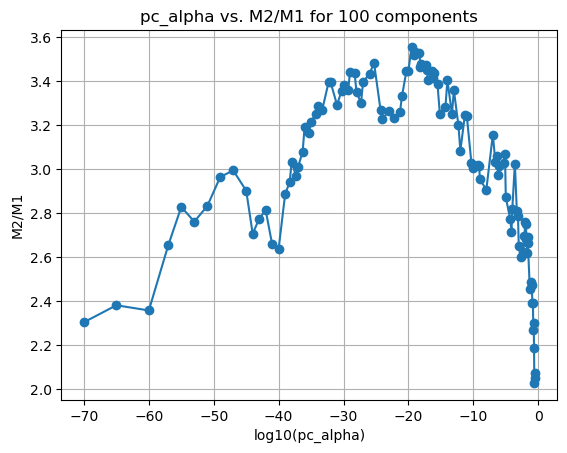

In [21]:
sorted_list_filteredComp = sorted(filteredComp, key=lambda x: x[0][1])


x_values = [np.log10(entry[0][1]) for entry in sorted_list_filteredComp] 
y_values = [entry[1][1] for entry in sorted_list_filteredComp]
filtered_values = [(x, y) for x, y in zip(x_values, y_values) if x >= -70] #optional filtering

plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('log10(pc_alpha)')
plt.ylabel('M2/M1')
plt.grid(True) 

#plt.savefig('./BilderBA/p_mat_l2_distance.pdf', format='pdf')
plt.title('pc_alpha vs. M2/M1 for ' + str(filterElement) + ' components')

plt.show()

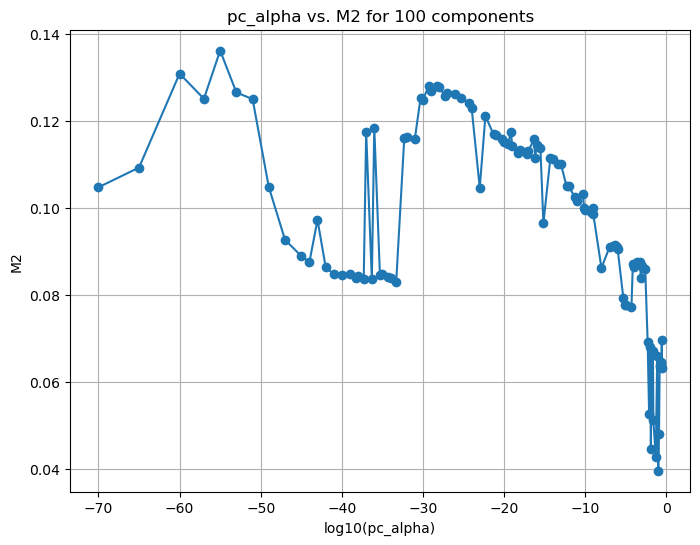

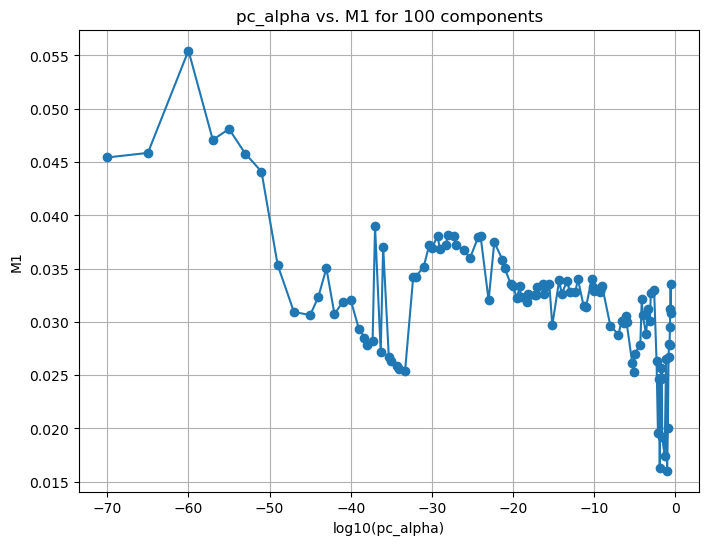

In [22]:
pcvsmetric2 = sorted([(entry[0][1], entry[1][2]) for entry in filteredComp], key=lambda x: x[0])
pcvsmetric1 = sorted([(entry[0][1], entry[1][3]) for entry in filteredComp], key=lambda x: x[0])

x_values = [np.log10(entry[0]) for entry in pcvsmetric2]
y_values = [entry[1] for entry in pcvsmetric2]

plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('log10(pc_alpha)')
plt.ylabel('M2')
plt.grid(True)
plt.title('pc_alpha vs. M2 for ' + str(filterElement) + ' components')

#plt.savefig('./BilderBA/pc_alpha_fullvsM2.pdf', format='pdf')
plt.show()


x_values2 = [np.log10(entry[0]) for entry in pcvsmetric1]
y_values2 = [entry[1] for entry in pcvsmetric1]

plt.figure(figsize=(8, 6))
plt.plot(x_values2, y_values2, marker='o', linestyle='-')

plt.xlabel('log10(pc_alpha)')
plt.ylabel('M1')
plt.grid(True)
plt.title('pc_alpha vs. M1 for ' + str(filterElement) + ' components')

#plt.savefig('./BilderBA/pc_alpha_fullvsM1.pdf', format='pdf')

plt.show()

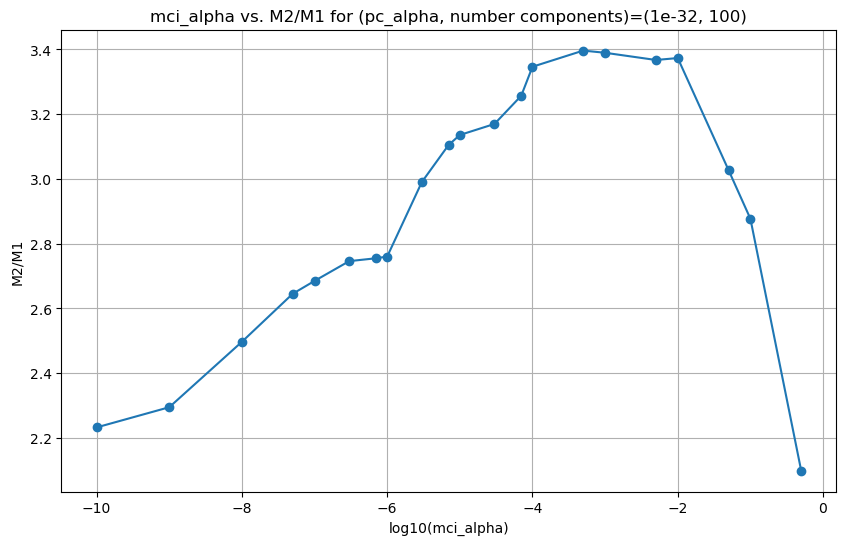

In [23]:
filterPcAlphaAndComps=(1e-32, 100)
data=metric2_div_metric1[filterPcAlphaAndComps] #choose (pc_alpha, number components) to plot mci_alpha vs M2/M1


x = [entry[0] for entry in data]
y = [entry[1] for entry in data]

x_log = np.log10(x)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_log, y, marker='o', linestyle='-')

plt.xlabel('log10(mci_alpha)')
plt.ylabel('M2/M1')

plt.title('mci_alpha vs. M2/M1 for (pc_alpha, number components)=' + str(filterPcAlphaAndComps))

#plt.savefig('./BilderBA/mcialphabis-75.pdf', format='pdf')

plt.grid(True)

plt.show()


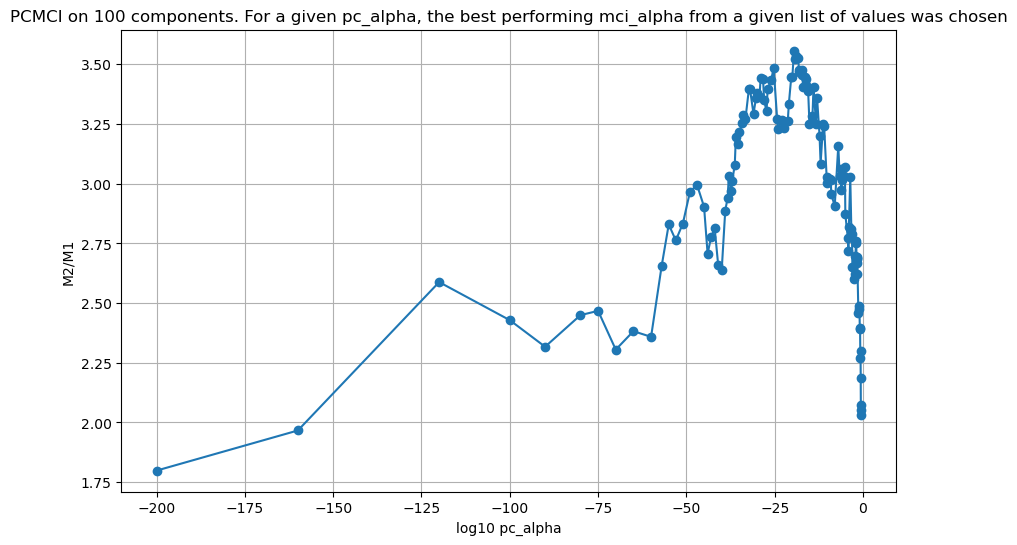

In [24]:
filtered_data100 = [item for item in temp if item[0][0] == 100] #pc_alpha vs. M2/M1
sorted_data100 = sorted(filtered_data100, key=lambda x: x[0][1])  
data = sorted_data100

x_values = [entry[0][1] for entry in data]  
y_values = [entry[1][1] for entry in data]  

x_values_log10 = np.log10(x_values)

plt.figure(figsize=(10, 6))
plt.plot(x_values_log10, y_values, marker='o', linestyle='-')
plt.xlabel('log10 pc_alpha')
plt.ylabel('M2/M1')
plt.title('PCMCI on 100 components. For a given pc_alpha, the best performing mci_alpha from a given list of values was chosen')
plt.grid(True)
#plt.savefig('./BilderBA/'+'+pctests100comps'+'.pdf',dpi=600)

plt.show()

In [25]:
def scatter_plot_2(data,model_nr,title,name,save_name,vmin,vmax,nr_intervals,label):
    size_s=40
    nr_models=len(data[:,0,0,0])
    average=0
    n_ensembles=nr_intervals
    all_values = []  # Hier werden alle Werte gesammelt

    for i in range(0,nr_models):
#         print i                                                                                                                                                                                                                                                           
#         if name[i]==name[model_nr]:                                                                                                                                                                                                                                       
#             print name[i]                                                                                                                                                                                                                                                 
        if name[i] in ['era', 'NCEP']: #2*datashape 3
            plt.scatter(np.ones((nr_intervals**2))*i,data[model_nr,i,:,:].flatten(),color='red',s=size_s)
#             print name[i],np.nanmean(data[model_nr,i,:,:],axis=(0,1))                                                                                                                                                                                                     
            if i==model_nr:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)     #da auch r zu k
            else:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)
        else:
#             print name[i],data[model_nr,i,:,:].flatten()[0:n_ensembles]                                                                                                                                                                                                   
            plt.scatter(np.ones(4*4)*i,data[model_nr,i,:,:].flatten(),color='red',s=size_s)
#             print name[i],np.nanmean(data[model_nr,i,:,:],axis=(0,1))                                                                                                                                                                                                     
            if i==model_nr:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)              #da x color ändern
            else:
                average+=np.nanmean(data[model_nr,i,:,:],axis=(0,1))
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)
        all_values.extend(data[model_nr, i, :, :].flatten())

    min_value = np.nanmin(all_values)
    max_value = np.nanmax(all_values)

    
    
    #### REVISE
    average/=(nr_models-1) #    average/=double(nr_models-1)
    print('average', average)
    plt.plot(np.linspace(-0.5,nr_models+1,100)-0.25,np.ones((100))*average,color='gray',linestyle='--',linewidth=2)
    plt.xticks(np.arange(0,nr_models),name[:],rotation=90,size=12)
    plt.ylabel(label,size=16,fontweight='bold')
    plt.xlim(-0.5,nr_models-0.5)
    #plt.ylim(vmin,vmax)
    plt.ylim(max(0, min_value-0.1), min(1, max_value+0.1))
    plt.title('Reference: ' + model_names[model_nr],fontweight='bold',size=12)
    title='Reference: ' + model_names[model_nr]
    #plt.savefig('./BilderBA/'+title+'(100, 3e-20, 0.0001)F1PENALTY60.pdf', dpi=600, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

In [26]:
def scatter_plot_2_(data, model_nr, title, name, save_name, vmin, vmax, nr_intervals, label): #different scaling
    size_s = 40
    nr_models = len(data[:, 0, 0, 0])
    average = 0
    n_ensembles = nr_intervals
    all_values = []  # Hier werden alle Werte gesammelt

    for i in range(0, nr_models):
        if name[i] in ['era', 'NCEP']:
            plt.scatter(np.ones((nr_intervals**2)) * i, data[model_nr, i, :, :].flatten(), color='red', s=size_s)
            if i == model_nr:
                plt.scatter(i, np.nanmean(data[model_nr, i, :, :], axis=(0, 1)), marker='x', color='k', linewidth=2, s=size_s)
            else:
                plt.scatter(i, np.nanmean(data[model_nr, i, :, :], axis=(0, 1)), marker='x', color='k', linewidth=2, s=size_s)
        else:
            plt.scatter(np.ones(4*4) * i, data[model_nr, i, :, :].flatten(), color='red', s=size_s)
            if i == model_nr:
                plt.scatter(i, np.nanmean(data[model_nr, i, :, :], axis=(0, 1)), marker='x', color='k', linewidth=2, s=size_s)
            else:
                average += np.nanmean(data[model_nr, i, :, :], axis=(0, 1))
                plt.scatter(i, np.nanmean(data[model_nr, i, :, :], axis=(0, 1)), marker='x', color='k', linewidth=2, s=size_s)
        all_values.extend(data[model_nr, i, :, :].flatten())

    min_value = np.nanmin(all_values)
    max_value = np.nanmax(all_values)

    average /= (nr_models - 1)
    plt.plot(np.linspace(-0.5, nr_models + 1, 100) - 0.25, np.ones((100)) * average, color='gray', linestyle='--', linewidth=2)
    plt.xticks(np.arange(0, nr_models), name[:], rotation=90, size=12)
    plt.ylabel(label, size=16, fontweight='bold')
    plt.xlim(-0.5, nr_models - 0.5)
    plt.ylim(min_value-0.01, max_value+0.01)  # change scalings
    plt.title('Reference: ' + model_names[model_nr],fontweight='bold',size=12)

    title='Reference: ' + model_names[model_nr]
   # plt.savefig('./BilderBA/'+title+'(100, 3e-20, 0.0001)F1PENALTY60.pdf', dpi=600, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()
    i+=1

In [27]:
metric2_div_metric1=dict(sorted(metric2_div_metric1.items(), key=lambda x: x[0][1]))

In [28]:
#-----for each nr. components, print the pc_alpha which achieves the highest F1-Score-----


temp={}
#pc_lpha, comps = zip((list(metric2_div_metric1_maxs.keys())))
temp2=list(metric2_div_metric1_maxs.keys())
pc_alpha, comps = zip(*temp2)
pc_alpha=list(set(pc_alpha))
comps=list(set(comps))
for key in comps:
    temp.setdefault(key, [])
    
for key in metric2_div_metric1_maxs:
    temp[key[1]].append((key[0], metric2_div_metric1_maxs[key][1]))
    
temp=dict(sorted(temp.items()))



## pandas dataframes ##

In [29]:
filter_pcAlpha_pdDf=0.2 #hyperparameter setting for dataframe visualizations
filter_mciAlpha_pdDf=1e-5
filter_nrComponents_pdDf=100

In [30]:
#Pandas Dataframe for Metric1

pandasDfList=[]
for key1 in f1Scores_.keys():
    for key2 in f1Scores_[key1].keys():
        if key2 == filter_mciAlpha_pdDf:
#            print(np.nanmean(metric1(f1Scores_[key1][key2])), key1, key2)
            pandasDfList.append((np.nanmean(metric1(f1Scores_[key1][key2])), key1, key2))




df = pd.DataFrame(pandasDfList, columns=['Metric1', 'Nr. components', 'pc_alpha'])

df['pc_alpha'] = df['Nr. components'].apply(lambda x: x[0])
df['Nr. components'] = df['Nr. components'].apply(lambda x: x[1])
_,_,mci_alpha = zip(*pandasDfList)
df['mci_alpha']=mci_alpha


df_sorted = df.sort_values(by='Nr. components', ascending=True)

df_filtered_m1vscomps = df_sorted.loc[df_sorted['pc_alpha'] == filter_pcAlpha_pdDf]

df_filtered_m1vspcalpha = df.sort_values(by='pc_alpha', ascending=True)
df_filtered_m1vspcalpha = df.loc[df['Nr. components'] == filter_nrComponents_pdDf]


#---now for all mci_alpha---
pandasDfList2=[]
for key1 in f1Scores_.keys():
    for key2 in f1Scores_[key1].keys():
        pandasDfList2.append((np.nanmean(metric1(f1Scores_[key1][key2])), key1, key2))
        
df2data=[]
for element in pandasDfList2:
    df2data.append((element[0], element[1][1], element[1][0], np.log10(element[2])))
    
df2 = pd.DataFrame(df2data, columns=['Metric1', 'Nr. components', 'pc_alpha', 'log10(mci_alpha)'])

df_filtered_m1vsmcialpha_temp = df2.loc[df2['Nr. components'] == filter_nrComponents_pdDf]
df_filtered_m1vsmcialpha = df_filtered_m1vsmcialpha_temp.loc[df_filtered_m1vsmcialpha_temp['pc_alpha'] == filter_pcAlpha_pdDf]

In [31]:
df_filtered_m1vsmcialpha

,Metric1,Nr. components,pc_alpha,log10(mci_alpha)
3465,0.081407,100,0.2,-10.000000
3466,0.077010,100,0.2,-9.000000
3467,0.073880,100,0.2,-8.000000
3468,0.067347,100,0.2,-7.301030
3469,0.066225,100,0.2,-7.000000
3470,0.060852,100,0.2,-6.522879
3471,0.055836,100,0.2,-6.154902
3472,0.055004,100,0.2,-6.000000
3473,0.053779,100,0.2,-5.522879
3474,0.050877,100,0.2,-5.154902


In [32]:
pandasDfList3=[]
relatedModels=related_models[0]
refModelIndex=6
for key1 in f1Scores_.keys():
    for key2 in f1Scores_[key1].keys():
        pandasDfList3.append((metric2_(key1, None, relatedModels, refModelIndex, key2)[1], key1[1], key1[0], key2))   #only for metric2_ !!! metric2 for HadGEM3 only
    
df3 = pd.DataFrame(pandasDfList3, columns=['Metric2', 'Nr. components', 'pc_alpha', 'mci_alpha'])



df3_filtered_m2vsnrcomponents=(df3.loc[df2['pc_alpha'] == filter_pcAlpha_pdDf]).loc[df3['mci_alpha'] == filter_mciAlpha_pdDf]
df3_filtered_m2vsnrcomponents = df3_filtered_m2vsnrcomponents.sort_values(by='Nr. components', ascending=True)


df3_filtered_m2vspcalpha=(df3.loc[df2['Nr. components'] == filter_nrComponents_pdDf]).loc[df3['mci_alpha'] == filter_mciAlpha_pdDf]
df3_filtered_m2vspcalpha = df3_filtered_m2vspcalpha.sort_values(by='pc_alpha', ascending=True)


df3_filtered_m2vsmcialpha=(df3.loc[df2['Nr. components'] == filter_nrComponents_pdDf]).loc[df3['pc_alpha'] == filter_pcAlpha_pdDf]
df3_filtered_m2vsmcialpha = df3_filtered_m2vsmcialpha.sort_values(by='mci_alpha', ascending=True)







In [33]:
df3_filtered_m2vsnrcomponents

,Metric2,Nr. components,pc_alpha,mci_alpha
3559,0.110837,3,0.2,0.00001
3622,0.123493,5,0.2,0.00001
3454,0.127262,10,0.2,0.00001
3496,0.092532,15,0.2,0.00001
3517,0.097019,20,0.2,0.00001
3538,0.083442,25,0.2,0.00001
3580,0.091542,30,0.2,0.00001
3601,0.067806,40,0.2,0.00001
3643,0.074284,50,0.2,0.00001
3664,0.082916,65,0.2,0.00001


## further matplotlib visualizations based on pandas dataframes ##

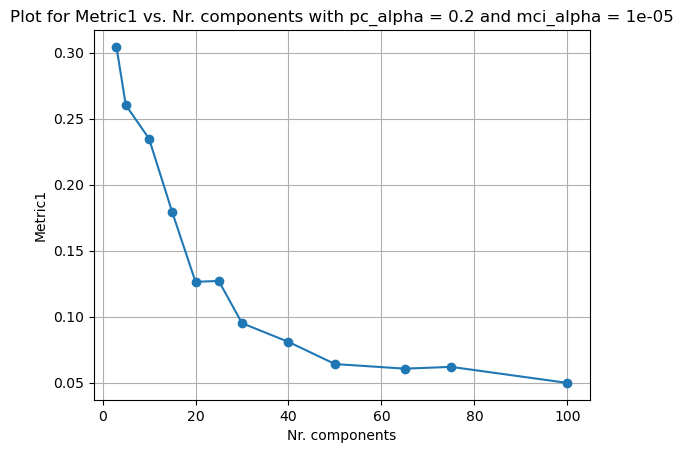

In [34]:
plt.plot(df_filtered_m1vscomps['Nr. components'], df_filtered_m1vscomps['Metric1'], marker='o', linestyle='-')
plt.xlabel('Nr. components')
plt.ylabel('Metric1')

title='Plot for Metric1 vs. Nr. components with pc_alpha = ' + str(filter_pcAlpha_pdDf) + ' and mci_alpha = ' + str(filter_mciAlpha_pdDf)
plt.title(title)
plt.grid(True)
#plt.savefig('./images/gridSearch/' + title + '.pdf')
plt.show()


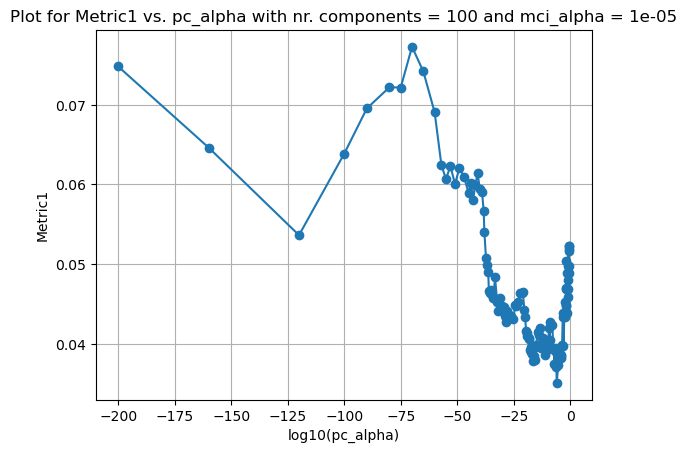

In [35]:
df_filtered_m1vspcalpha_sorted = df_filtered_m1vspcalpha.sort_values(by='pc_alpha')

# Transformieren Sie die pc_alpha-Werte in log10
log_pc_alpha = np.log10(df_filtered_m1vspcalpha_sorted['pc_alpha'])

# Erstellen Sie das Diagramm mit den transformierten pc_alpha-Werten
plt.plot(log_pc_alpha, df_filtered_m1vspcalpha_sorted['Metric1'], marker='o', linestyle='-')
plt.xlabel('log10(pc_alpha)')
plt.ylabel('Metric1')

title='Plot for Metric1 vs. pc_alpha with nr. components = ' + str(filter_nrComponents_pdDf) + ' and mci_alpha = ' + str(filter_mciAlpha_pdDf)
plt.title(title)
plt.grid(True)
#plt.savefig('./images/gridSearch/' + title + '.pdf')
plt.show()

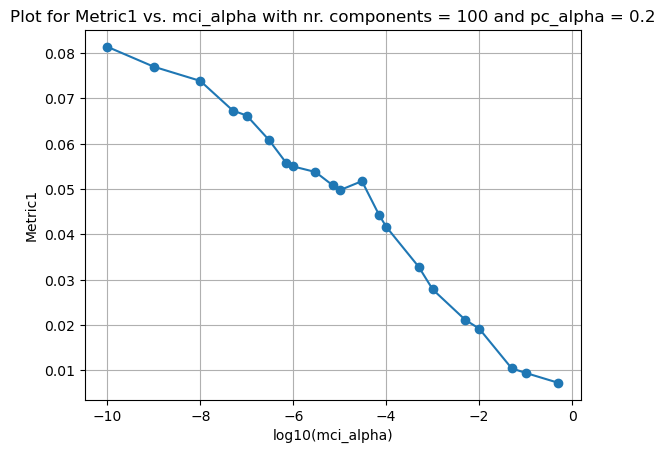

In [36]:
plt.plot(df_filtered_m1vsmcialpha['log10(mci_alpha)'], df_filtered_m1vsmcialpha['Metric1'], marker='o', linestyle='-')
plt.xlabel('log10(mci_alpha)')
plt.ylabel('Metric1')

title='Plot for Metric1 vs. mci_alpha with nr. components = ' + str(filter_nrComponents_pdDf) + ' and pc_alpha = ' + str(filter_pcAlpha_pdDf)
plt.title(title)
plt.grid(True)
#plt.savefig('./images/gridSearch/' + title + '.pdf')
plt.show()


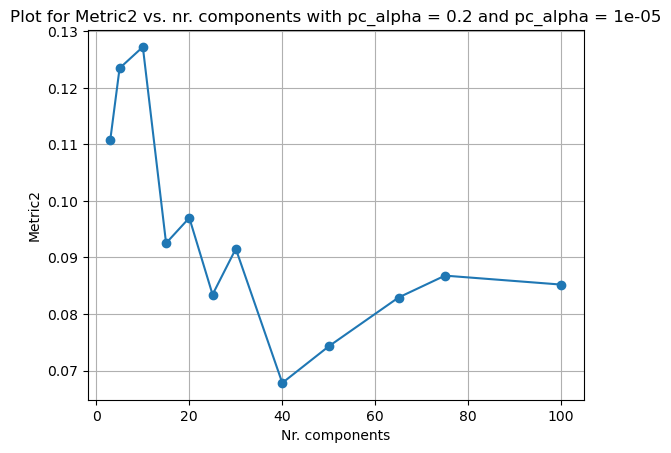

In [37]:
plt.plot(df3_filtered_m2vsnrcomponents['Nr. components'], df3_filtered_m2vsnrcomponents['Metric2'], marker='o', linestyle='-')
plt.xlabel('Nr. components')
plt.ylabel('Metric2')

title='Plot for Metric2 vs. nr. components with pc_alpha = ' + str(filter_pcAlpha_pdDf) + ' and pc_alpha = ' + str(filter_mciAlpha_pdDf)
plt.title(title)
plt.grid(True)
#plt.savefig('./images/gridSearch/' + title + '.pdf')
plt.show()


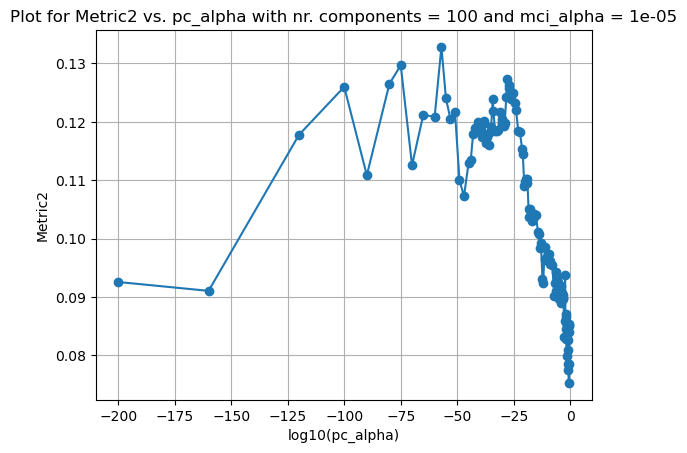

In [38]:
log_pc_alpha = np.log10(df_filtered_m1vspcalpha_sorted['pc_alpha'])

plt.plot(log_pc_alpha, df3_filtered_m2vspcalpha['Metric2'], marker='o', linestyle='-')
plt.xlabel('log10(pc_alpha)')  # Setzen Sie das Label für die x-Achse
plt.ylabel('Metric2')  # Setzen Sie das Label für die y-Achse

# Titel setzen
title='Plot for Metric2 vs. pc_alpha with nr. components = ' + str(filter_nrComponents_pdDf) + ' and mci_alpha = ' + str(filter_mciAlpha_pdDf)
plt.title(title)

# Setzen der logarithmischen Skalierung für die x-Achse

plt.grid(True)  # Gitterlinien anzeigen
#plt.savefig('./images/gridSearch/' + title + '.pdf')
plt.show()  # Plot anzeigen

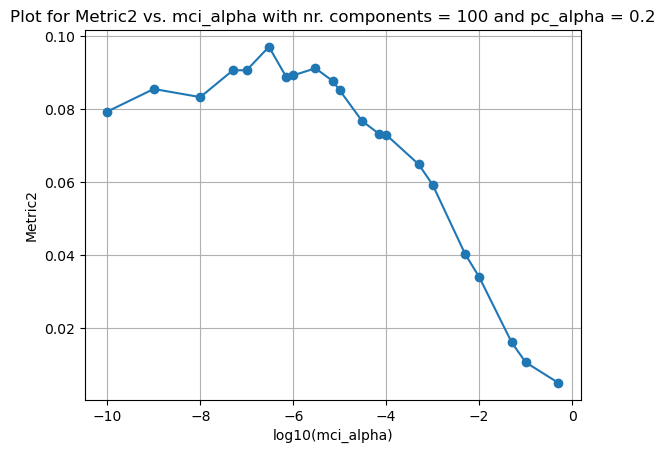

In [39]:
plt.plot(np.log10(df3_filtered_m2vsmcialpha['mci_alpha']), df3_filtered_m2vsmcialpha['Metric2'], marker='o', linestyle='-')
plt.xlabel('log10(mci_alpha)')
plt.ylabel('Metric2')

title='Plot for Metric2 vs. mci_alpha with nr. components = ' + str(filter_nrComponents_pdDf) + ' and pc_alpha = ' + str(filter_pcAlpha_pdDf)
plt.title(title)
plt.grid(True)
#plt.savefig('./images/gridSearch/' + title + '.pdf')
plt.show()


In [40]:
#for key in metric2_div_metric1.keys():
 #   if key[1] > 50:
  #      plot_metric2_div_metric1(key)
#generates huge amount of images...

# Visualization of the climate model discrepancies #

(100, 3e-20, 0.0001)
average 0.41599929415985415


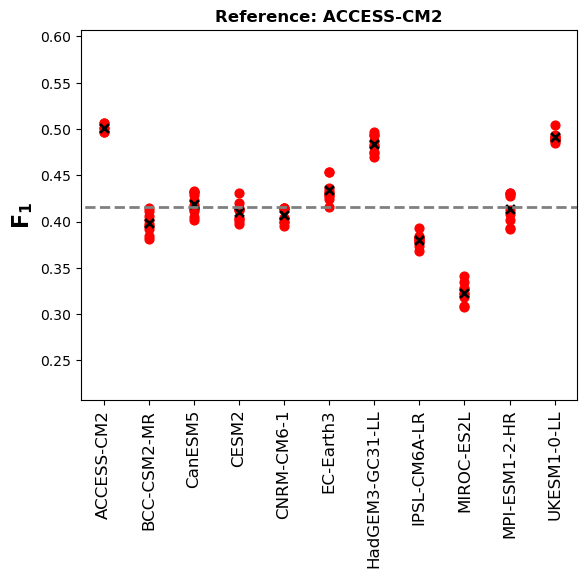

average 0.38796748086396743


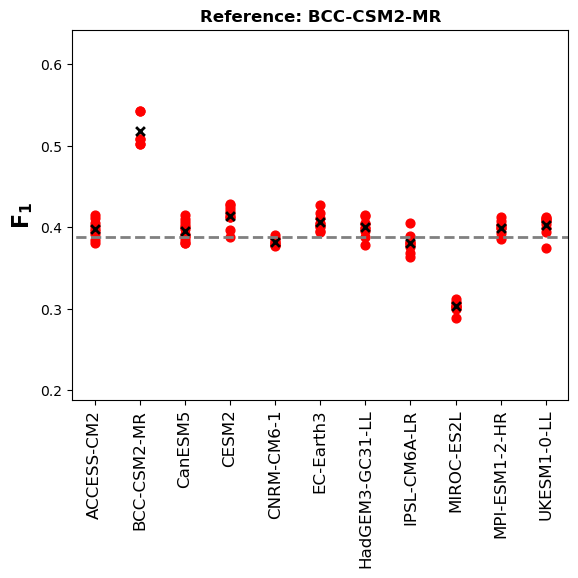

average 0.3983707407835529


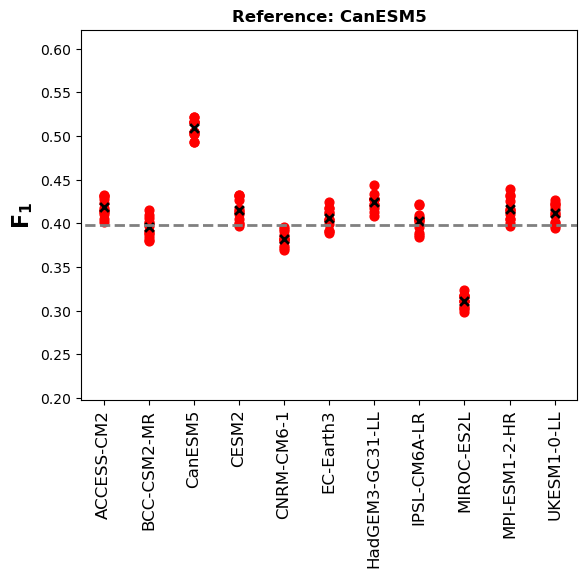

average 0.38827672035177396


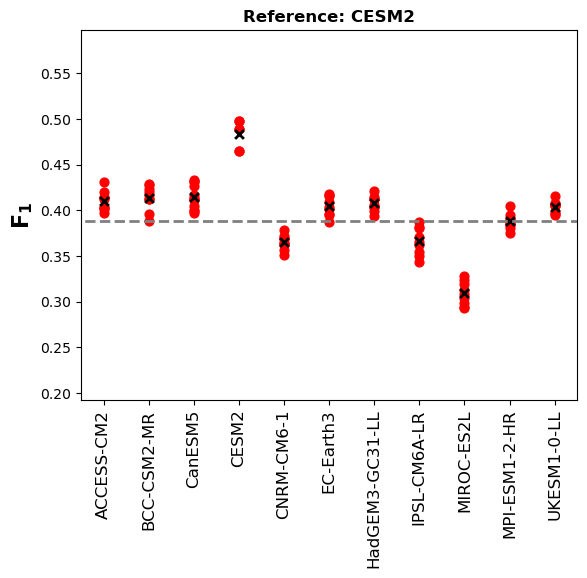

average 0.40692723475247883


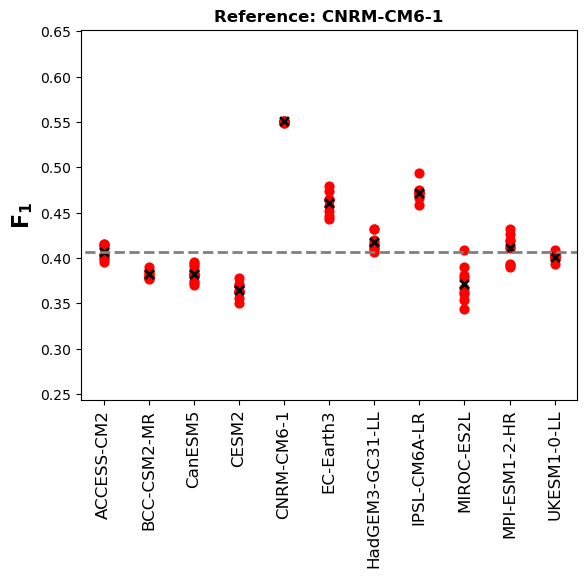

average 0.4263605950549854


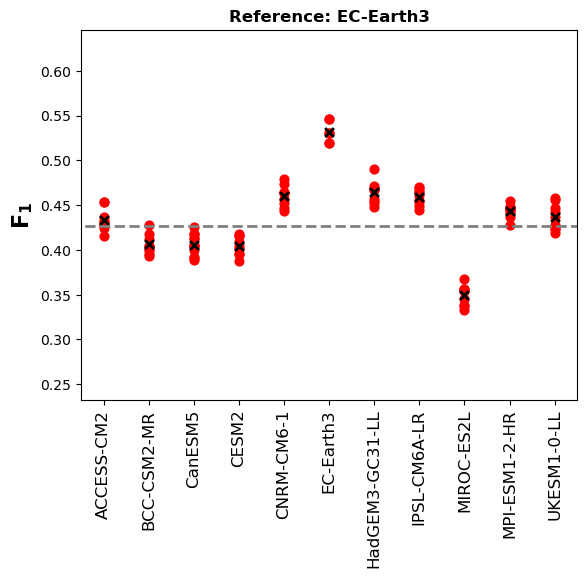

average 0.4262401021832988


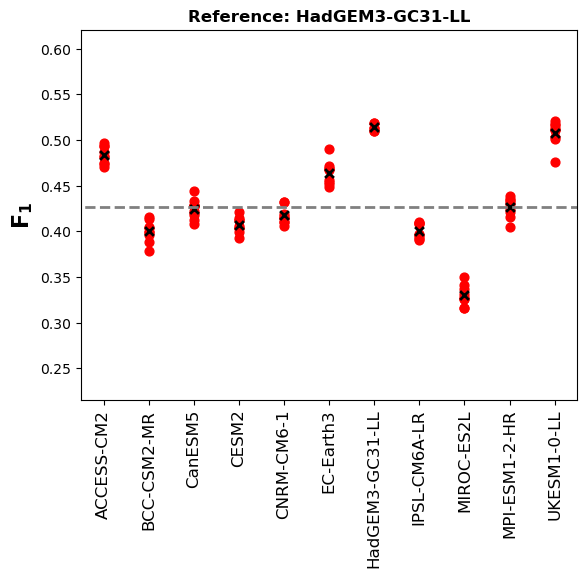

average 0.400578205924268


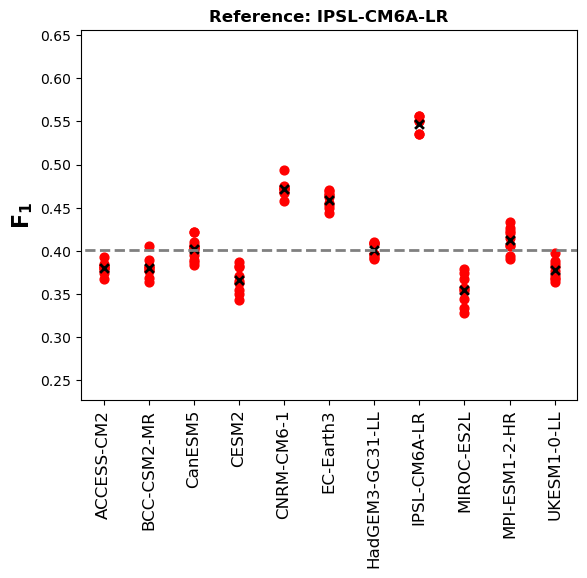

average 0.3311268396443045


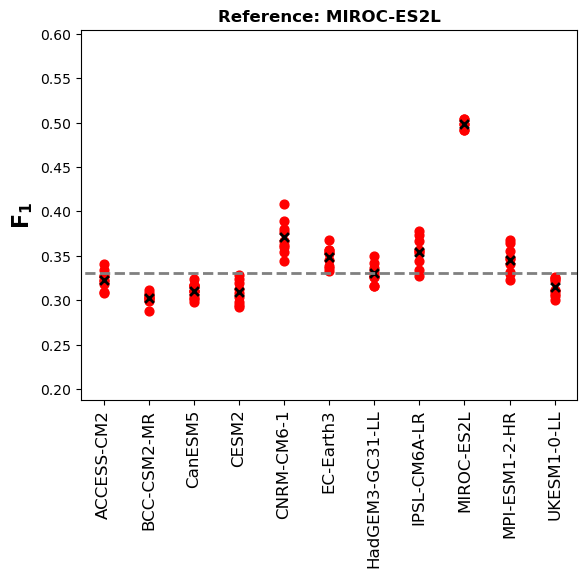

average 0.4065352750128093


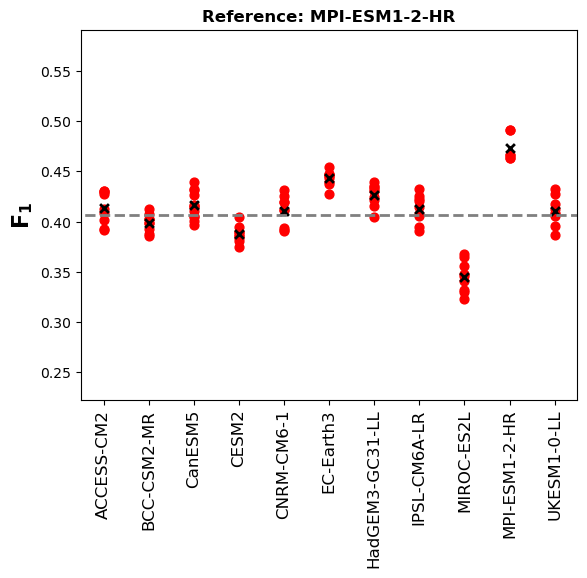

average 0.41573743469469493


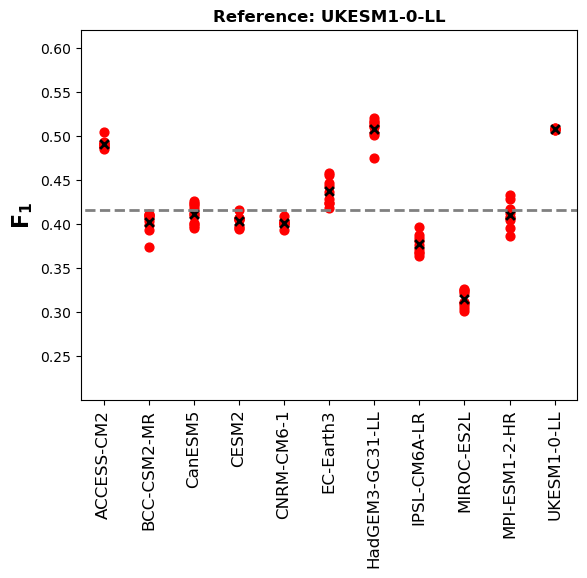

In [41]:
for key in sorted_dict_komps:
    if key[0]>=25:
        if key != (100, 3e-20, 0.0001):   #combination of (number components, pc_alpha, mci_alpha) to plot
            continue
        print(key)
        for refModelIndex, model in enumerate(model_names):
            scatter_plot_2(f1Scores_[(key[1],key[0])][key[2]], refModelIndex, "comps: " + str(key[0]) + "|pc_alpha: " + str (key[1]) + "|alpha_value: " + str(key[2]), model_names, 'scatterplot2', 0.5, 1, 3, r'F$_{\mathbf{1}}$')

## setup for comparison on observation data ##

In [42]:
def get_metric_f1(ref_p_matrix, p_matrix, ref_val_matrix, val_matrix, alpha, 
            tau_min=0, tau_diff=1, same_sign=True):
    tau_diff=0
    N, N, taumaxp1 = val_matrix.shape
    TP = 0
    FP = 0
    FN = 0
    auto = 0
    count = 0
    for i in range(N):
        for j in range(N):
            if i != j:
                for tau in range(tau_min, taumaxp1):
                    if tau==0:
                        if i<j:
                            if ref_p_matrix[i,j,tau] > alpha and p_matrix[i,j,tau] < alpha:
                                FP += 1
                            elif ref_p_matrix[i,j,tau] < alpha and np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha): #dann gibt es vlt. einen nicht contemp. link i->j oder contemp. link o-o 
                                count +=1
                                if same_sign==True and np.sign(ref_val_matrix[i,j,tau]) == np.sign(val_matrix[i,j,tau]):
                                    TP += 1
                                elif same_sign==True and np.sign(ref_val_matrix[i,j,tau]) != np.sign(val_matrix[i,j,tau]):
                                    FN += 1
                                elif same_sign==False:
                                    TP += 1
                            elif ref_p_matrix[i,j,tau] < alpha and np.any(p_matrix[j,i,max(0,tau-tau_diff):tau+tau_diff+1] < alpha): #dann gibt es vlt. einen nicht contemp. link j->i oder contemp. link o-o
                                count +=1
                                if same_sign==True and np.sign(ref_val_matrix[i,j,tau]) == np.sign(val_matrix[j,i,tau]):
                                    TP += 1
                                elif same_sign==True and np.sign(ref_val_matrix[i,j,tau]) != np.sign(val_matrix[j,i,tau]):
                                    FN += 1
                                elif same_sign==False:
                                    TP += 1
                            elif ref_p_matrix[i,j,tau] < alpha and not(np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha)):
                                FN += 1
                            elif ref_p_matrix[i,j,tau] < alpha and not(np.any(p_matrix[j,i,max(0,tau-tau_diff):tau+tau_diff+1] < alpha)):
                                FN += 1
                    else:
                        if ref_p_matrix[i,j,tau] > alpha and p_matrix[i,j,tau] < alpha:
                            FP += 1
                        elif ref_p_matrix[i,j,tau] < alpha and np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha):
                            count +=1
                            if same_sign==True and np.sign(ref_val_matrix[i,j,tau]) == np.sign(val_matrix[i,j,tau]):
                                TP += 1
                            elif same_sign==True and np.sign(ref_val_matrix[i,j,tau]) != np.sign(val_matrix[i,j,tau]):
                                FN += 1
                            elif same_sign==False:
                                TP += 1
                        elif ref_p_matrix[i,j,tau] < alpha and not(np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha)):
                            FN += 1
            else:
                auto +=1
    precision =  float(TP+1e-10) / float(TP + FP +1e-10)
    recall = float(TP+1e-10) / float(TP + FN +1e-10)
    f1 = 2.0*precision*recall/float(precision + recall)
    return precision, recall, TP, FP, FN, f1, auto, count

In [43]:
def f1score_modelAll(ref_dataset, val_mat_dict, p_mat_dict, link_mat_dic, alpha_levelTest, f14d):
    df_f1score= {}
    ref_ds=ref_dataset
    val_mat_dic= val_mat_dict
    p_mat_dic=p_mat_dict
    score_list =[]
    score_list2=[]
    for season in link_mat_dic:
        if season !="global":#drop global
            for dataset in link_mat_dic[season]:               
                for i, ensemble in enumerate(link_mat_dic[season][dataset]):
                    if (dataset!=ref_ds or dataset==ref_ds) and dataset!='ncar':
                        datasetIndex=model_names.index(dataset)
                        refdatasetIndex=model_names.index(ref_dataset)
                        for j, ref_ds_ensemble in enumerate(link_mat_dic[season][ref_ds]):                      
                            #von hier
                            ref_p_matrix= p_mat_dic[season][ref_ds][ref_ds_ensemble]
                            ref_val_matrix= val_mat_dic[season][ref_ds][ref_ds_ensemble]
                            #bis hier über alle ref_ds gehen in for loop
                            p_matrix= p_mat_dic[season][dataset][ensemble]
                            val_matrix= val_mat_dic[season][dataset][ensemble]
                            precision, recall, TP, FP, FN, score, auto, count = get_metric_f1(ref_p_matrix, p_matrix, ref_val_matrix, val_matrix, alpha_levelTest, 
                            tau_min=1, tau_diff=2, same_sign=True)
                            score_list.append([season,dataset,ensemble,score])
                            score_list2.append([season,dataset,ensemble,score,ref_ds_ensemble])
                            if not ((datasetIndex==refdatasetIndex) and (i==j)):                               
                                f14d[refdatasetIndex][datasetIndex][j][i]=score 

    season,dataset,ensemble,score= [list(a) for a in zip(*score_list)]
    df_f1score_ = pd.DataFrame({"season":season,"model":dataset,"ensemble":ensemble,"F1-score":score})
    #get average F1-score over seasons
    df_f1score_seasonaveraged = df_f1score_.groupby(["model"])["F1-score"].mean().rename("F1-score",inplace=True).to_frame()
    return score_list2

In [44]:
pcmci_res_path="./output/gridSearch/alpha=3e-20_nVAR=100" #choose folder with PCMCI results
alpha_levelTest=0.0001 #choose mci_alpha
make_dic=True 
use_CMIP6_data = True

In [45]:
model_names=['ACCESS-CM2', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-CM6-1', 'EC-Earth3', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC-ES2L',
             'MPI-ESM1-2-HR', 'UKESM1-0-LL', 'ncar']

In [46]:
graph_mat_dict={}
val_mat_dict={}
p_mat_dict={}
allResults={}

for res_file in glob.glob(pcmci_res_path+"/results_*.bin"):       
    res = pickle.load(open(res_file,"rb"))
    resTest = res
    resTest1=resTest
    pc_alpha=resTest1['PC_params']['pc_alpha']            
    tau_max=resTest1['PC_params']['tau_max']
    file_nameTest = resTest1['file_name']

    n_kept_comp=len(resTest1['PC_params']['selected_variables'])
    selected_comps_indices=[i for i in range(0,n_kept_comp)]
    var_names=["X_"+str(i) for i in range(0,n_kept_comp)]

    name=file_nameTest
    print(f"calculating for {name} with alphaLevel = {alpha_levelTest}")
    file_nameTest = pca_res_path+"/"+ file_nameTest
    info_model= file_nameTest.split("_")
    #print("info model liste ist ", info_model)
    dataset_name = info_model[2]               #on error change to 2 or 3
    ensemble=""
    if dataset_name != "ncar":
        dataset_name= info_model[2] #same
        if use_CMIP6_data:
            ensemble= info_model[5]  #on error change to 5 or 6
        else : ensemble= info_model[7]
    if dataset_name == "GISS-E2-R":
        ensemble= info_model[5]
    if dataset_name == "ERA5":
        ensemble= ""
    season= info_model[-1][7:-4]


    datadictTest = cPickle.load(open(file_nameTest, 'rb'))
    dTest = datadictTest['results']
    time_maskTest = dTest['time_mask']
    dateseriesTest = dTest['time'][:]
    fulldataTest = dTest['ts_unmasked']
    N = fulldataTest.shape[1]
    fulldata_mask = np.repeat(time_maskTest.reshape(len(dTest['time']), 1), N, axis=1)

    fulldataTest = fulldataTest[:, selected_comps_indices]
    fulldata_mask = fulldata_mask[:, selected_comps_indices]
    dataframeTest = pp.DataFrame(fulldataTest, mask=fulldata_mask)
    T, N = dataframeTest.values[0].shape
    CI_params = {       'significance':'analytic', 
                                'mask_type':['y'],
                                'recycle_residuals':False,
                                }
    cond_ind_test = ParCorr(**CI_params)
    pcmci=PCMCI(cond_ind_test=cond_ind_test,dataframe=dataframeTest, verbosity=0)



    graphTest = pcmci.get_graph_from_pmatrix(p_matrix=resTest1['results']['p_matrix'],
                                    alpha_level=alpha_levelTest,
                                    tau_min=1,
                                    tau_max=10,
                                    link_assumptions=None,)

    valMatrixTest = resTest1['results']['val_matrix']

    graph_mat_dict.setdefault(season,{})
    graph_mat_dict[season].setdefault(dataset_name,{})
    graph_mat_dict[season][dataset_name]
    graph_mat_dict[season][dataset_name][ensemble] = graphTest
    val_mat_dict.setdefault(season,{})
    val_mat_dict[season].setdefault(dataset_name,{})
    val_mat_dict[season][dataset_name].setdefault(ensemble,None)
    val_mat_dict[season][dataset_name][ensemble]=valMatrixTest
    p_mat_dict.setdefault(season,{})
    p_mat_dict[season].setdefault(dataset_name,{})
    p_mat_dict[season][dataset_name].setdefault(ensemble,)
    p_mat_dict[season][dataset_name][ensemble]=resTest1['results']['p_matrix']
    allResults.setdefault(alpha_levelTest, {})
    allResults[alpha_levelTest].setdefault('graph_mat_dict', {})
    allResults[alpha_levelTest].setdefault('val_mat_dict', {})
    allResults[alpha_levelTest].setdefault('p_mat_dict', {})       
    allResults[alpha_levelTest]['graph_mat_dict']=graph_mat_dict
    allResults[alpha_levelTest]['val_mat_dict']=val_mat_dict
    allResults[alpha_levelTest]['p_mat_dict']=p_mat_dict

calculating for varimax_CMIP6_ACCESS-CM2_day_historical_r1i1p1f1_psl_1979-2014_detrend.nc_100-comps_timebin-3_months-[6, 7, 8].bin with alphaLevel = 0.0001
calculating for varimax_CMIP6_ACCESS-CM2_day_historical_r2i1p1f1_psl_1979-2014_detrend.nc_100-comps_timebin-3_months-[6, 7, 8].bin with alphaLevel = 0.0001
calculating for varimax_CMIP6_ACCESS-CM2_day_historical_r3i1p1f1_psl_1979-2014_detrend.nc_100-comps_timebin-3_months-[6, 7, 8].bin with alphaLevel = 0.0001
calculating for varimax_CMIP6_BCC-CSM2-MR_day_historical_r1i1p1f1_psl_1979-2014_detrend.nc_100-comps_timebin-3_months-[6, 7, 8].bin with alphaLevel = 0.0001
calculating for varimax_CMIP6_BCC-CSM2-MR_day_historical_r2i1p1f1_psl_1979-2014_detrend.nc_100-comps_timebin-3_months-[6, 7, 8].bin with alphaLevel = 0.0001
calculating for varimax_CMIP6_BCC-CSM2-MR_day_historical_r3i1p1f1_psl_1979-2014_detrend.nc_100-comps_timebin-3_months-[6, 7, 8].bin with alphaLevel = 0.0001
calculating for varimax_CMIP6_CanESM5_day_historical_r1i1p1f1

In [47]:
resDict={}
for key in allResults.keys():
    modelRes=allResults[key]
    graph_mat_dict=modelRes['graph_mat_dict']
    val_mat_dict=modelRes['val_mat_dict']
    p_mat_dict=modelRes['p_mat_dict']
    f14d=np.empty((len(model_names), len(model_names), 4, 4))
    shape=(len(model_names), len(model_names), 4, 4)
    f14d = np.full(shape, np.nan)

    x=f1score_modelAll('ncar', val_mat_dict, p_mat_dict, graph_mat_dict, key, f14d)

    resDict[key]=f14d

In [48]:
def scatter_plot_2(data,model_nr,title,name,save_name,vmin,vmax,nr_intervals,label):
    size_s=40
    nr_models=len(data[:,0,0,0])
    average=0
    n_ensembles=nr_intervals
    all_values = []  # Hier werden alle Werte gesammelt

    for i in range(0,nr_models):
        if i== 11:
            continue
#         print i                                                                                                                                                                                                                                                           
#         if name[i]==name[model_nr]:                                                                                                                                                                                                                                       
#             print name[i]                                                                                                                                                                                                                                                 
        if name[i] in ['era', 'NCEP']: #2*datashape 3
            plt.scatter(np.ones((nr_intervals**2))*i,data[model_nr,i,:,:].flatten(),color='red',s=size_s)
#             print name[i],np.nanmean(data[model_nr,i,:,:],axis=(0,1))                                                                                                                                                                                                     
            if i==model_nr:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)     
            else:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)
        else:
#             print name[i],data[model_nr,i,:,:].flatten()[0:n_ensembles]                                                                                                                                                                                                   
            plt.scatter(np.ones(4*4)*i,data[model_nr,i,:,:].flatten(),color='red',s=size_s)
#             print name[i],np.nanmean(data[model_nr,i,:,:],axis=(0,1))                                                                                                                                                                                                     
            if i==model_nr:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)             
            else:
                average+=np.nanmean(data[model_nr,i,:,:],axis=(0,1))
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)
        all_values.extend(data[model_nr, i, :, :].flatten())

    min_value = np.nanmin(all_values)
    max_value = np.nanmax(all_values)

    
    
     #### REVISE
    average/=(nr_models-1) #    average/=double(nr_models-1)
    print('average', average)
    plt.plot(np.linspace(-0.5,nr_models+1,100)-0.25,np.ones((100))*average,color='gray',linestyle='--',linewidth=2)
    plt.xticks(np.arange(0,nr_models-0),name[:],rotation=90,size=12)
    plt.ylabel(label,size=16,fontweight='bold')
    plt.xlim(-0.5, nr_models - 1 - 0.5)  
    #plt.ylim(vmin,vmax)
    plt.ylim(max(0, min_value-0.1), min(1, max_value+0.1))
    #plt.title(title,fontweight='bold',size=12)
    plt.title('Reference: ' + 'ncar' ,fontweight='bold',size=12)
  #  plt.savefig('./BilderBA/ncarvspcalpha=3e-20.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

## climade models vs. observation data ##

average 0.40706370407243425


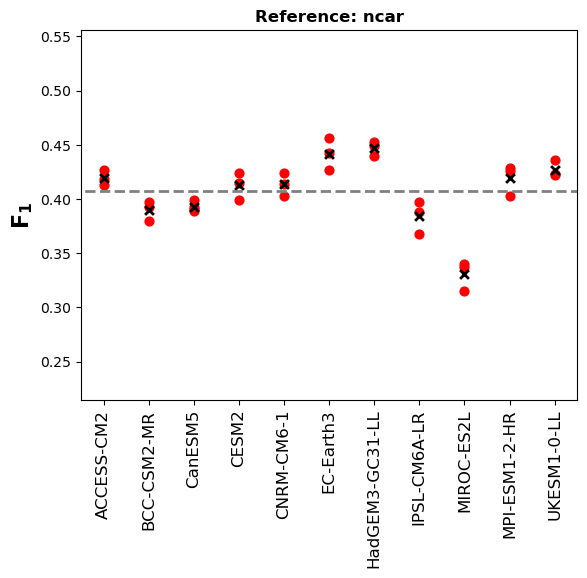

In [49]:
scatter_plot_2(resDict[alpha_levelTest], 11, "comps: " + str(100) + "|pc_alpha: " + str (3e-25) + "|alpha_value: " + str(0.001), model_names, 'scatterplot2', 0.5, 1, 3, r'F$_{\mathbf{1}}$') #